# CIFAR-100 Training - Optimized for 74% Accuracy

## Key Improvements:
- Fixed data augmentation (proper Cutout implementation)
- Cosine annealing scheduler with warmup
- Optimized hyperparameters (batch size 256, MixUp alpha 0.2)
- Label smoothing (0.1)
- Gradient clipping
- Mixed precision training
- Model checkpointing and early stopping
- WideResNet-28-10 (36.5M parameters)

In [1]:
# Import Libraries
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import os

# CIFAR-100 Mean and Std
cifar100_mean = (0.5071, 0.4865, 0.4409)
cifar100_std = (0.2673, 0.2564, 0.2761)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Improved Data Augmentation
class ImprovedAlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5, size=(32, 32)),
            A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5),  # Cutout
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

# Instantiate transforms
train_transforms = ImprovedAlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
])

# CIFAR-100 Dataset with increased batch size
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

# DataLoaders with batch size 256
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

cifar100_classes = datasets.CIFAR100(root='./data', train=False).classes
print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1751441270.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5, size=(32, 32)),
/tmp/ipython-input-1751441270.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5),  # Cutout
100%|██████████| 169M/169M [00:14<00:00, 11.9MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware

Training batches: 196, Test batches: 40


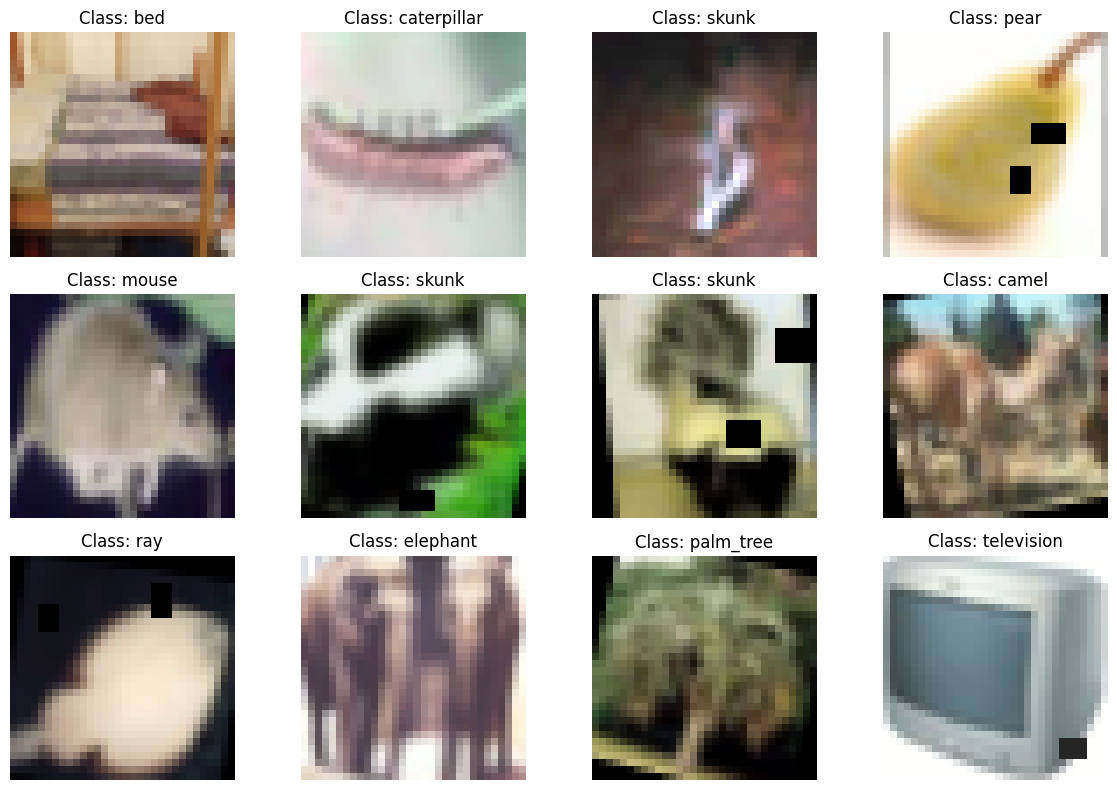

In [3]:
# Visualize augmented samples
import matplotlib.pyplot as plt
import numpy as np

batch_data, batch_label = next(iter(train_loader))
batch_data = batch_data.cpu().detach()

fig = plt.figure(figsize=(12, 8))
for i in range(12):
    img = batch_data[i].numpy().transpose((1, 2, 0))
    # Denormalize
    img = img * np.array(cifar100_std) + np.array(cifar100_mean)
    img = np.clip(img, 0, 1)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {cifar100_classes[batch_label[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# WideResNet Architecture
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.equalInOut = in_planes == out_planes
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropRate = dropRate
        self.shortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, 1, stride=stride, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.conv1(out if self.equalInOut else x)
        out = self.relu2(self.bn2(out))
        if self.dropRate > 0:
            out = F.dropout(out, p=self.dropRate, training=self.training)
        out = self.conv2(out)
        return out + (x if self.equalInOut else self.shortcut(x))


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=100, widen_factor=10, dropRate=0.3):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [5]:
# Initialize model
model = WideResNet(depth=28, widen_factor=10, dropRate=0.3, num_classes=100).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 160, 32, 32]          23,040
       BatchNorm2d-5          [-1, 160, 32, 32]             320
              ReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7          [-1, 160, 32, 32]         230,400
            Conv2d-8          [-1, 160, 32, 32]           2,560
        BasicBlock-9          [-1, 160, 32, 32]               0
      BatchNorm2d-10          [-1, 160, 32, 32]             320
             ReLU-11          [-1, 160, 32, 32]               0
           Conv2d-12          [-1, 160, 32, 32]         230,400
      BatchNorm2d-13          [-1, 160, 32, 32]             320
             ReLU-14          [-1, 160,

In [6]:
# MixUp function
def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [7]:
# Learning Rate Warmup Scheduler
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, initial_lr, target_lr, steps_per_epoch):
        self.optimizer = optimizer
        self.warmup_steps = warmup_epochs * steps_per_epoch
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.current_step = 0

    def step(self):
        if self.current_step < self.warmup_steps:
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * self.current_step / self.warmup_steps
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_step += 1

    def is_warmup(self):
        return self.current_step < self.warmup_steps

In [8]:
# Training function with mixed precision and gradient clipping
def train(model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
          use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Mixed precision training
        with autocast():
            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
                outputs = model(inputs)
                loss = lam * F.cross_entropy(outputs, targets_a, label_smoothing=label_smoothing) + \
                       (1 - lam) * F.cross_entropy(outputs, targets_b, label_smoothing=label_smoothing)
            else:
                outputs = model(data)
                loss = F.cross_entropy(outputs, target, label_smoothing=label_smoothing)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        # Update learning rate
        if warmup_scheduler.is_warmup():
            warmup_scheduler.step()
        else:
            scheduler.step()

        # Accuracy tracking
        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)
        total_loss += loss.item()

        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}% LR={current_lr:.6f}")

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / processed
    return avg_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    return test_loss, accuracy

In [13]:
# Training Configuration
print("=" * 70)
print("Training Configuration:")
print("=" * 70)
print(f"Model: WideResNet-28-10 (36.5M parameters)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"MixUp Alpha: 0.2")
print(f"Label Smoothing: 0.1")
print(f"Weight Decay: 1e-3")
print(f"Gradient Clipping: 1.0")
print(f"Scheduler: CosineAnnealingWarmRestarts")
print(f"Warmup: 5 epochs (0.01 -> 0.1)")
print(f"Mixed Precision: Enabled")
print("=" * 70)

# Optimizer and Scheduler
EPOCHS = 100
WARMUP_EPOCHS = 5
INITIAL_LR = 0.01
MAX_LR = 0.1
MIN_LR = 1e-4

optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=0.9, weight_decay=1e-3)

# Cosine annealing with warm restarts (T_0 = 25 epochs per cycle)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=MIN_LR)

# Warmup scheduler
warmup_scheduler = WarmupScheduler(optimizer, WARMUP_EPOCHS, INITIAL_LR, MAX_LR, len(train_loader))

# Gradient scaler for mixed precision
scaler = GradScaler()

# Tracking variables
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
learning_rates = []

# Early stopping and checkpointing
best_test_acc = 0.0
patience = 15
patience_counter = 0
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

Training Configuration:
Model: WideResNet-28-10 (36.5M parameters)
Batch Size: 256
MixUp Alpha: 0.2
Label Smoothing: 0.1
Weight Decay: 1e-3
Gradient Clipping: 1.0
Scheduler: CosineAnnealingWarmRestarts
Warmup: 5 epochs (0.01 -> 0.1)
Mixed Precision: Enabled


/tmp/ipython-input-100415171.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [14]:
# Training Loop
print("\nStarting training...\n")

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_acc = train(
        model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
        use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1
    )

    # Test
    test_loss, test_acc = test(model, device, test_loader)

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_accuracy': test_acc,
            'train_accuracy': train_acc,
        }, os.path.join(checkpoint_dir, 'best_model.pth'))
        print(f"*** New best model saved! Test Accuracy: {best_test_acc:.2f}% ***")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}. No improvement for {patience} epochs.")
        break

    # Check if target reached
    if test_acc >= 74.0:
        print(f"\n{'=' * 70}")
        print(f"Target accuracy of 74% reached at epoch {epoch}!")
        print(f"Final test accuracy: {test_acc:.2f}%")
        print(f"{'=' * 70}")
        break

    print(f"Best Test Accuracy so far: {best_test_acc:.2f}% | Patience: {patience_counter}/{patience}\n")

print(f"\nTraining completed. Best test accuracy: {best_test_acc:.2f}%")


Starting training...



  0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipython-input-580392809.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Loss=4.0823 Acc=9.59% LR=0.027908: 100%|██████████| 196/196 [01:54<00:00,  1.71it/s]



Test set: Average loss: 3.7942, Accuracy: 1180/10000 (11.80%)

*** New best model saved! Test Accuracy: 11.80% ***
Best Test Accuracy so far: 11.80% | Patience: 0/15



Epoch 2 Loss=3.7155 Acc=12.84% LR=0.045908: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 3.4765, Accuracy: 1666/10000 (16.66%)

*** New best model saved! Test Accuracy: 16.66% ***
Best Test Accuracy so far: 16.66% | Patience: 0/15



Epoch 3 Loss=3.2755 Acc=17.90% LR=0.063908: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 3.1981, Accuracy: 2177/10000 (21.77%)

*** New best model saved! Test Accuracy: 21.77% ***
Best Test Accuracy so far: 21.77% | Patience: 0/15



Epoch 4 Loss=3.3021 Acc=21.63% LR=0.081908: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.9313, Accuracy: 2789/10000 (27.89%)

*** New best model saved! Test Accuracy: 27.89% ***
Best Test Accuracy so far: 27.89% | Patience: 0/15



Epoch 5 Loss=3.0757 Acc=26.86% LR=0.099908: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 2.8277, Accuracy: 2868/10000 (28.68%)

*** New best model saved! Test Accuracy: 28.68% ***
Best Test Accuracy so far: 28.68% | Patience: 0/15



Epoch 6 Loss=3.3878 Acc=34.37% LR=0.000712: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 2.1833, Accuracy: 4364/10000 (43.64%)

*** New best model saved! Test Accuracy: 43.64% ***
Best Test Accuracy so far: 43.64% | Patience: 0/15



Epoch 7 Loss=2.6028 Acc=37.20% LR=0.002398: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 2.1192, Accuracy: 4509/10000 (45.09%)

*** New best model saved! Test Accuracy: 45.09% ***
Best Test Accuracy so far: 45.09% | Patience: 0/15



Epoch 8 Loss=2.5927 Acc=38.13% LR=0.004739: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 2.0751, Accuracy: 4564/10000 (45.64%)

*** New best model saved! Test Accuracy: 45.64% ***
Best Test Accuracy so far: 45.64% | Patience: 0/15



Epoch 9 Loss=3.1159 Acc=39.75% LR=0.007158: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 2.0535, Accuracy: 4667/10000 (46.67%)

*** New best model saved! Test Accuracy: 46.67% ***
Best Test Accuracy so far: 46.67% | Patience: 0/15



Epoch 10 Loss=2.8407 Acc=39.63% LR=0.009055: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.0076, Accuracy: 4730/10000 (47.30%)

*** New best model saved! Test Accuracy: 47.30% ***
Best Test Accuracy so far: 47.30% | Patience: 0/15



Epoch 11 Loss=2.4253 Acc=41.25% LR=0.009961: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.9544, Accuracy: 4856/10000 (48.56%)

*** New best model saved! Test Accuracy: 48.56% ***
Best Test Accuracy so far: 48.56% | Patience: 0/15



Epoch 12 Loss=2.7929 Acc=41.07% LR=0.000448: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.9442, Accuracy: 4872/10000 (48.72%)

*** New best model saved! Test Accuracy: 48.72% ***
Best Test Accuracy so far: 48.72% | Patience: 0/15



Epoch 13 Loss=2.3663 Acc=40.44% LR=0.001895: 100%|██████████| 196/196 [01:54<00:00,  1.71it/s]



Test set: Average loss: 1.9272, Accuracy: 4950/10000 (49.50%)

*** New best model saved! Test Accuracy: 49.50% ***
Best Test Accuracy so far: 49.50% | Patience: 0/15



Epoch 14 Loss=2.3932 Acc=42.35% LR=0.004122: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.8875, Accuracy: 4980/10000 (49.80%)

*** New best model saved! Test Accuracy: 49.80% ***
Best Test Accuracy so far: 49.80% | Patience: 0/15



Epoch 15 Loss=3.6845 Acc=43.01% LR=0.006580: 100%|██████████| 196/196 [01:51<00:00,  1.75it/s]



Test set: Average loss: 1.8728, Accuracy: 5006/10000 (50.06%)

*** New best model saved! Test Accuracy: 50.06% ***
Best Test Accuracy so far: 50.06% | Patience: 0/15



Epoch 16 Loss=2.8693 Acc=42.65% LR=0.008658: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.8390, Accuracy: 5138/10000 (51.38%)

*** New best model saved! Test Accuracy: 51.38% ***
Best Test Accuracy so far: 51.38% | Patience: 0/15



Epoch 17 Loss=2.4668 Acc=44.51% LR=0.009844: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.8123, Accuracy: 5191/10000 (51.91%)

*** New best model saved! Test Accuracy: 51.91% ***
Best Test Accuracy so far: 51.91% | Patience: 0/15



Epoch 18 Loss=2.6438 Acc=45.65% LR=0.000256: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.7819, Accuracy: 5209/10000 (52.09%)

*** New best model saved! Test Accuracy: 52.09% ***
Best Test Accuracy so far: 52.09% | Patience: 0/15



Epoch 19 Loss=2.2753 Acc=44.22% LR=0.001442: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.7954, Accuracy: 5251/10000 (52.51%)

*** New best model saved! Test Accuracy: 52.51% ***
Best Test Accuracy so far: 52.51% | Patience: 0/15



Epoch 20 Loss=2.6281 Acc=44.50% LR=0.003520: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.7818, Accuracy: 5258/10000 (52.58%)

*** New best model saved! Test Accuracy: 52.58% ***
Best Test Accuracy so far: 52.58% | Patience: 0/15



Epoch 21 Loss=2.6428 Acc=45.22% LR=0.005978: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.7739, Accuracy: 5305/10000 (53.05%)

*** New best model saved! Test Accuracy: 53.05% ***
Best Test Accuracy so far: 53.05% | Patience: 0/15



Epoch 22 Loss=2.4370 Acc=44.30% LR=0.008205: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.7465, Accuracy: 5384/10000 (53.84%)

*** New best model saved! Test Accuracy: 53.84% ***
Best Test Accuracy so far: 53.84% | Patience: 0/15



Epoch 23 Loss=3.5886 Acc=45.85% LR=0.009652: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.7279, Accuracy: 5442/10000 (54.42%)

*** New best model saved! Test Accuracy: 54.42% ***
Best Test Accuracy so far: 54.42% | Patience: 0/15



Epoch 24 Loss=3.0609 Acc=47.21% LR=0.000139: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.6856, Accuracy: 5504/10000 (55.04%)

*** New best model saved! Test Accuracy: 55.04% ***
Best Test Accuracy so far: 55.04% | Patience: 0/15



Epoch 25 Loss=2.4346 Acc=47.35% LR=0.001045: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.6859, Accuracy: 5499/10000 (54.99%)

Best Test Accuracy so far: 55.04% | Patience: 1/15



Epoch 26 Loss=2.9701 Acc=47.49% LR=0.002942: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.7022, Accuracy: 5438/10000 (54.38%)

Best Test Accuracy so far: 55.04% | Patience: 2/15



Epoch 27 Loss=3.0447 Acc=48.11% LR=0.005361: 100%|██████████| 196/196 [01:51<00:00,  1.75it/s]



Test set: Average loss: 1.6858, Accuracy: 5476/10000 (54.76%)

Best Test Accuracy so far: 55.04% | Patience: 3/15



Epoch 28 Loss=3.5875 Acc=47.74% LR=0.007702: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.6640, Accuracy: 5607/10000 (56.07%)

*** New best model saved! Test Accuracy: 56.07% ***
Best Test Accuracy so far: 56.07% | Patience: 0/15



Epoch 29 Loss=2.3933 Acc=49.52% LR=0.009388: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.6668, Accuracy: 5545/10000 (55.45%)

Best Test Accuracy so far: 56.07% | Patience: 1/15



Epoch 30 Loss=2.5287 Acc=50.78% LR=0.010000: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.6211, Accuracy: 5677/10000 (56.77%)

*** New best model saved! Test Accuracy: 56.77% ***
Best Test Accuracy so far: 56.77% | Patience: 0/15



Epoch 31 Loss=2.3177 Acc=49.49% LR=0.000712: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.6383, Accuracy: 5675/10000 (56.75%)

Best Test Accuracy so far: 56.77% | Patience: 1/15



Epoch 32 Loss=3.1997 Acc=50.80% LR=0.002398: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.6152, Accuracy: 5716/10000 (57.16%)

*** New best model saved! Test Accuracy: 57.16% ***
Best Test Accuracy so far: 57.16% | Patience: 0/15



Epoch 33 Loss=2.3293 Acc=47.86% LR=0.004739: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.6344, Accuracy: 5664/10000 (56.64%)

Best Test Accuracy so far: 57.16% | Patience: 1/15



Epoch 34 Loss=3.6935 Acc=51.27% LR=0.007158: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.6201, Accuracy: 5677/10000 (56.77%)

Best Test Accuracy so far: 57.16% | Patience: 2/15



Epoch 35 Loss=2.8414 Acc=49.64% LR=0.009055: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.6236, Accuracy: 5701/10000 (57.01%)

Best Test Accuracy so far: 57.16% | Patience: 3/15



Epoch 36 Loss=2.3507 Acc=51.46% LR=0.009961: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.5548, Accuracy: 5889/10000 (58.89%)

*** New best model saved! Test Accuracy: 58.89% ***
Best Test Accuracy so far: 58.89% | Patience: 0/15



Epoch 37 Loss=1.9795 Acc=51.61% LR=0.000448: 100%|██████████| 196/196 [01:54<00:00,  1.71it/s]



Test set: Average loss: 1.5489, Accuracy: 5944/10000 (59.44%)

*** New best model saved! Test Accuracy: 59.44% ***
Best Test Accuracy so far: 59.44% | Patience: 0/15



Epoch 38 Loss=2.3323 Acc=51.15% LR=0.001895: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5859, Accuracy: 5909/10000 (59.09%)

Best Test Accuracy so far: 59.44% | Patience: 1/15



Epoch 39 Loss=1.9969 Acc=52.95% LR=0.004122: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.5681, Accuracy: 5955/10000 (59.55%)

*** New best model saved! Test Accuracy: 59.55% ***
Best Test Accuracy so far: 59.55% | Patience: 0/15



Epoch 40 Loss=3.7582 Acc=53.03% LR=0.006580: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.6252, Accuracy: 5816/10000 (58.16%)

Best Test Accuracy so far: 59.55% | Patience: 1/15



Epoch 41 Loss=2.1051 Acc=51.35% LR=0.008658: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5735, Accuracy: 5988/10000 (59.88%)

*** New best model saved! Test Accuracy: 59.88% ***
Best Test Accuracy so far: 59.88% | Patience: 0/15



Epoch 42 Loss=2.1378 Acc=52.02% LR=0.009844: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5088, Accuracy: 6079/10000 (60.79%)

*** New best model saved! Test Accuracy: 60.79% ***
Best Test Accuracy so far: 60.79% | Patience: 0/15



Epoch 43 Loss=2.5824 Acc=53.91% LR=0.000256: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5217, Accuracy: 6074/10000 (60.74%)

Best Test Accuracy so far: 60.79% | Patience: 1/15



Epoch 44 Loss=2.1222 Acc=53.77% LR=0.001442: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5289, Accuracy: 6053/10000 (60.53%)

Best Test Accuracy so far: 60.79% | Patience: 2/15



Epoch 45 Loss=1.9399 Acc=53.13% LR=0.003520: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5393, Accuracy: 6072/10000 (60.72%)

Best Test Accuracy so far: 60.79% | Patience: 3/15



Epoch 46 Loss=2.6410 Acc=54.39% LR=0.005978: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5607, Accuracy: 5974/10000 (59.74%)

Best Test Accuracy so far: 60.79% | Patience: 4/15



Epoch 47 Loss=2.0733 Acc=54.87% LR=0.008205: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5955, Accuracy: 5912/10000 (59.12%)

Best Test Accuracy so far: 60.79% | Patience: 5/15



Epoch 48 Loss=2.6262 Acc=54.46% LR=0.009652: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5116, Accuracy: 6172/10000 (61.72%)

*** New best model saved! Test Accuracy: 61.72% ***
Best Test Accuracy so far: 61.72% | Patience: 0/15



Epoch 49 Loss=2.8926 Acc=54.51% LR=0.000139: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.5004, Accuracy: 6206/10000 (62.06%)

*** New best model saved! Test Accuracy: 62.06% ***
Best Test Accuracy so far: 62.06% | Patience: 0/15



Epoch 50 Loss=3.6024 Acc=55.95% LR=0.001045: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5156, Accuracy: 6150/10000 (61.50%)

Best Test Accuracy so far: 62.06% | Patience: 1/15



Epoch 51 Loss=2.3185 Acc=56.46% LR=0.002942: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.4994, Accuracy: 6213/10000 (62.13%)

*** New best model saved! Test Accuracy: 62.13% ***
Best Test Accuracy so far: 62.13% | Patience: 0/15



Epoch 52 Loss=2.2610 Acc=57.78% LR=0.005361: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5081, Accuracy: 6153/10000 (61.53%)

Best Test Accuracy so far: 62.13% | Patience: 1/15



Epoch 53 Loss=2.1314 Acc=54.79% LR=0.007702: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.5532, Accuracy: 6067/10000 (60.67%)

Best Test Accuracy so far: 62.13% | Patience: 2/15



Epoch 54 Loss=2.7231 Acc=56.19% LR=0.009388: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.5265, Accuracy: 6151/10000 (61.51%)

Best Test Accuracy so far: 62.13% | Patience: 3/15



Epoch 55 Loss=2.3019 Acc=58.36% LR=0.010000: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.4556, Accuracy: 6330/10000 (63.30%)

*** New best model saved! Test Accuracy: 63.30% ***
Best Test Accuracy so far: 63.30% | Patience: 0/15



Epoch 56 Loss=2.1199 Acc=59.13% LR=0.000712: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.4439, Accuracy: 6411/10000 (64.11%)

*** New best model saved! Test Accuracy: 64.11% ***
Best Test Accuracy so far: 64.11% | Patience: 0/15



Epoch 57 Loss=1.9484 Acc=58.75% LR=0.002398: 100%|██████████| 196/196 [01:54<00:00,  1.72it/s]



Test set: Average loss: 1.4475, Accuracy: 6330/10000 (63.30%)

Best Test Accuracy so far: 64.11% | Patience: 1/15



Epoch 58 Loss=2.1982 Acc=56.77% LR=0.004739: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.5001, Accuracy: 6248/10000 (62.48%)

Best Test Accuracy so far: 64.11% | Patience: 2/15



Epoch 59 Loss=2.2311 Acc=58.67% LR=0.008205:  35%|███▌      | 69/196 [00:41<01:17,  1.65it/s]


KeyboardInterrupt: 

In [18]:
from huggingface_hub import HfApi

repo_id='pandurangpatil/erases8'
# Explicitly add the pytorch_model.bin file before pushing
api = HfApi()
api.upload_file(
    path_or_fileobj=os.path.join(checkpoint_dir, 'best_model.pth'),
    path_in_repo='best_model.pth',
    repo_id=repo_id,
    repo_type="model",
)

print(f"Model state dictionary saved locally to {os.path.join(checkpoint_dir, 'best_model.pth')} and uploaded to https://huggingface.co/{repo_id}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

Model state dictionary saved locally to ./checkpoints/best_model.pth and uploaded to https://huggingface.co/pandurangpatil/erases8


In [17]:
from huggingface_hub import notebook_login

notebook_login()

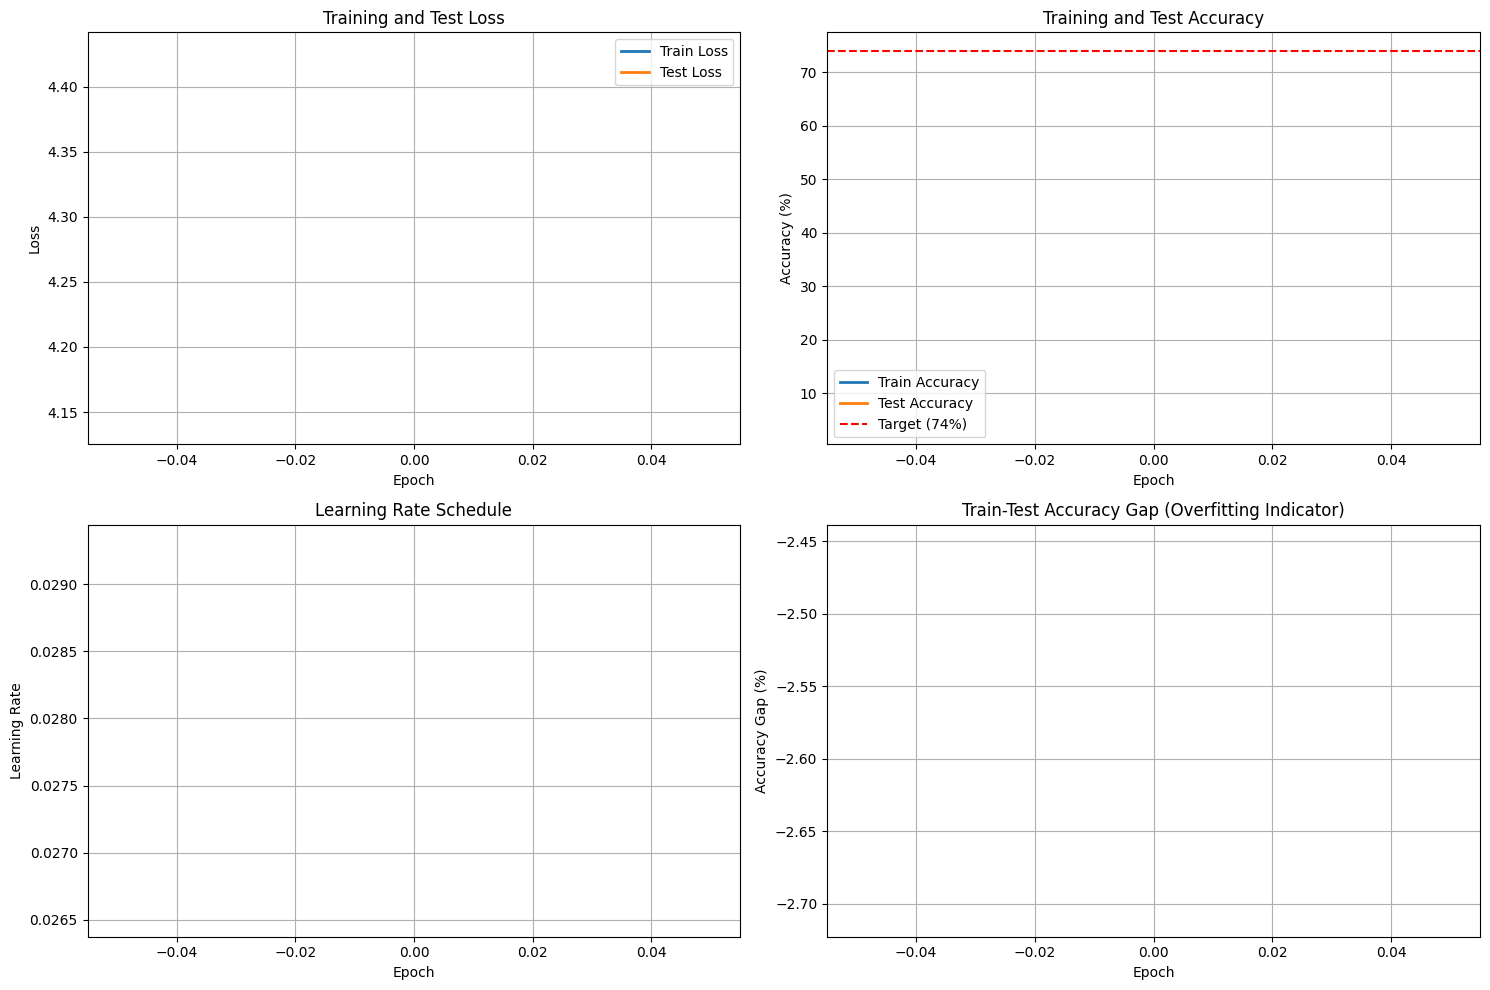


Final Statistics:
Best Test Accuracy: 6.60%
Final Train Accuracy: 4.02%
Final Test Accuracy: 6.60%
Final Train-Test Gap: -2.58%


In [11]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy curves
axes[0, 1].plot(train_accuracies, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accuracies, label='Test Accuracy', linewidth=2)
axes[0, 1].axhline(y=74, color='r', linestyle='--', label='Target (74%)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning rate
axes[1, 0].plot(learning_rates, linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True)

# Gap between train and test accuracy (overfitting indicator)
accuracy_gap = [train - test for train, test in zip(train_accuracies, test_accuracies)]
axes[1, 1].plot(accuracy_gap, linewidth=2, color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Gap (%)')
axes[1, 1].set_title('Train-Test Accuracy Gap (Overfitting Indicator)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Statistics:")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Final Train-Test Gap: {accuracy_gap[-1]:.2f}%")

In [12]:
# Load best model and evaluate
checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with test accuracy: {checkpoint['test_accuracy']:.2f}%")

# Final evaluation
test_loss, test_acc = test(model, device, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

Loaded best model from epoch 1 with test accuracy: 6.60%

Test set: Average loss: 4.1397, Accuracy: 660/10000 (6.60%)


Final Test Accuracy: 6.60%
